Define

In [1]:
import sys
import torch.utils.data as tordata
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
import SimpleITK as sitk

import torchvision
from datetime import datetime
from warnings import warn
from typing import Optional
# import torchvision.models as models
# %matplotlib inline
from collections import OrderedDict
import os
# from torchsummary import summary

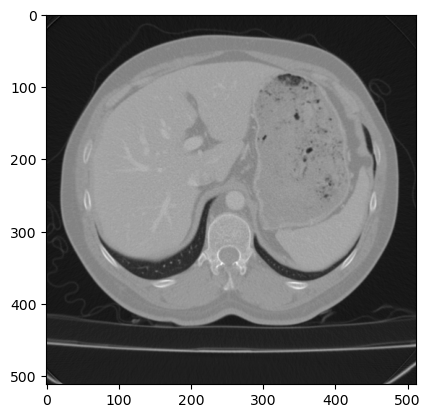

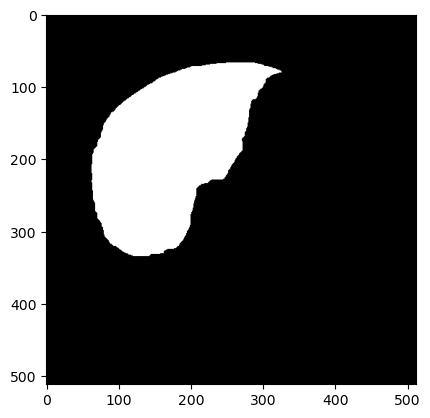

In [2]:
dicom_directory = '/bulk/liangy15/CHAOS/Train_Sets/CT/1/DICOM_anon/i0040,0000b.dcm'
ground_dir = '/bulk/liangy15/CHAOS/Train_Sets/CT/1/Ground/liver_GT_040.png'
# Read the DICOM file using pydicom
ds = sitk.ReadImage(dicom_directory)
image_np = sitk.GetArrayFromImage(ds)
ground = plt.imread(ground_dir)
plt.imshow(image_np[0], cmap='gray')
plt.show()
plt.imshow(ground, cmap='gray')
# ds = pydicom.dcmread(dicom_directory)
# image_np = ds.pixel_array



In [3]:
DATASET_PATH = '/bulk/liangy15/CHAOS/'
Train_Path = '/bulk/liangy15/CHAOS/Train_Sets/CT/'
Train_Set = [1,2,5,6,8,10,14,16,18,19,21,22,23,24,25,26,27,28,29,30]
Val_Set = [26,27,28,29,30]
Test_Set = [3,4,7,9,11,12,13,15,17,20,31,32,33,34,35,36,37,38,39,40]
Test_Path = '/bulk/liangy15/CHAOS/Test_Sets/CT/'

DataSet

In [4]:
class DataSet(tordata.Dataset):
    def __init__(self, path, set,  mode = []):
        super(DataSet, self).__init__()
        self.img_path_list = []
        self.ground_path_list = []
        self.path = path 
        self.mode = mode
        self.set = set
        self.data_path = []
        self.folder = []
        if mode == 'train':
            for i in range(len(set)):
                data_path = os.path.join(path, str(set[i]), 'DICOM_anon')
                data_path_img = os.listdir(data_path)
                try: data_path_img.sort(key=lambda x:int(x[1:5]))
                except: data_path_img.sort(key=lambda x:int(x[9:14]))
                ground_path = os.path.join(path, str(set[i]), 'Ground')
                data_path_ground = os.listdir(ground_path)
                data_path_ground.sort(key=lambda x:int(x[9:12]))
                for k in range(len(data_path_img)):
                    img_name = data_path_img[k]
                    ground_name = data_path_ground[k]
                    img_path = os.path.join(self.path, str(set[i]),'DICOM_anon', img_name)
                    ground_path = os.path.join(self.path, str(set[i]),'Ground', ground_name)
                    mask = plt.imread(ground_path)
                    if np.count_nonzero(mask) != 0:
                        self.img_path_list.append(img_path)
                        self.ground_path_list.append(ground_path)
        elif mode == 'test':
            for i in range(len(set)):
                data_path = os.path.join(path, str(set[i]), 'DICOM_anon')
                self.data_path.append(os.listdir(data_path))
                for j in range(len(os.listdir(data_path))):
                    self.folder.append(set[i])
            self.data_path = [item for sublist in self.data_path for item in sublist]
    def __getitem__(self, index):
        if self.mode == 'train':
            img_item_path = self.img_path_list[index]
            ground_item_path = self.ground_path_list[index]
            ds = sitk.ReadImage(img_item_path)
            data = sitk.GetArrayFromImage(ds)
            data = torch.tensor(data).float()
            data = torch.clamp(data, -160., 240.) 
            data = (data - torch.min(data))/(torch.max(data) - torch.min(data))
            mask = plt.imread(ground_item_path)
            mask = torch.tensor(mask).float()
            if torch.count_nonzero(mask) == 0:
                del self.data_path[index]
            else: return data, mask
        elif self.mode == 'test':
            img_name = self.data_path[index]
            img_item_path = os.path.join(self.path, str(self.folder[index]),'DICOM_anon', img_name)
            ds = sitk.ReadImage(img_item_path)
            data = sitk.GetArrayFromImage(ds)
            data = torch.tensor(data).float()
            data = torch.clamp(data, -160., 240.) 
            data = (data - torch.min(data))/(torch.max(data) - torch.min(data))
            return data
        
    def __len__(self):
        if self.mode == 'train':
            return len(self.img_path_list)
        else: return len(self.data_path)


In [5]:
trainsource = DataSet(Train_Path, Train_Set, mode='train')
valsource = DataSet(Train_Path, Val_Set, mode='train')
testsource = DataSet(Test_Path, Test_Set, mode = 'test')
print(len(trainsource), len(valsource), len(testsource))
# img, mask = trainsource[0]
# plt.imshow(img)
# print(img.size(), mask.size())

2341 742 3533


Net

In [6]:
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features = 32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        #x = x.view(-1, 1)
        x = x.view(-1,1,512,512)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        output = torch.sigmoid(self.conv(dec1))
        output = output.view(output.size(0),output.size(2), output.size(3))
        return output
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
# model = UNet().cuda()
# summary(model,(1,256,256), batch_size=1)


Loss

In [7]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, predict, target):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
       
        # num = predict.size(0)
        # pre = predict.view(num, -1)
        # tar = target.view(num, -1)

        tp = (predict*target).sum(self.dims)
        fp = (predict*(1-target)).sum(self.dims)
        fn = ((1-predict)*target).sum(self.dims)

        nominator = 2 * tp
        denominator = 2 * tp + fp + fn

        dc = (nominator + self.smooth) / (torch.clip(denominator + self.smooth, 1e-8))
        dc = dc.mean()
        
        return 1-dc


Model

In [8]:
class Model:
    def __init__(
        self,
        lr,
        num_workers,
        batch_size,
        restore_iter,
        total_epoch,
        save_name,
        model_name,
        train_source,
        val_source,
        test_source,
        prt_path):
        
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.restore_iter = restore_iter
        self.total_epoch = total_epoch
        self.save_name = save_name
        self.model_name = model_name
        self.train_source = train_source
        self.val_source = val_source
        self.test_source = test_source
        self.prt_path = prt_path

        net = UNet().cuda()
        self.net = nn.DataParallel(net)
        optimizer = optim.Adam([{'params':self.net.parameters(), 'lr': self.lr}])
        self.optimizer = optimizer
        loss = torchvision.ops.focal_loss.sigmoid_focal_loss
        self.loss = nn.DataParallel(loss)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, 40, gamma=0.5)
        
        self.dice_loss = []
        self.DICELOSS = []
    def fit(self):

        #self.load_pretrain(self.prt_path)
        
        if self.restore_iter != 0:
            self.load_model(self.restore_iter)
        self.net.train()
        train_loader = tordata.DataLoader(
                        dataset = self.train_source,
                        num_workers = self.num_workers,
                        batch_size = self.batch_size 
                        )
        
        #scaler = torch.cuda.amp.GradScaler()
        for epoch in range(self.restore_iter, self.total_epoch):
            _time1 = datetime.now()
            for i, x in enumerate(train_loader):
                imgs, masks = x
                # plt.imshow(np.array(imgs[0][0]), cmap = 'gray')
                # plt.show()
                # plt.imshow(np.array(masks[0]), cmap = 'gray')
                # plt.show()
                imgs = imgs.cuda()
                masks = masks.cuda()
                pred = self.net(imgs)
                dice_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(pred, masks).mean()
                self.dice_loss.append(dice_loss.cpu().data.numpy())
                self.optimizer.zero_grad()
                dice_loss.cuda().backward()
                self.optimizer.step() 
            self.scheduler.step()
                   
            print(datetime.now()-_time1)
            _time1 = datetime.now()
            self.save_model(epoch)
            print('epoch {}:'.format(epoch), end='')
            print(', dice_loss={0:.8f}'.format(np.mean(self.dice_loss)), end='')
            print(', lr=',self.optimizer.state_dict()['param_groups'][0]['lr'])
            sys.stdout.flush()
            self.DICELOSS.append(np.mean(self.dice_loss))
            self.dice_loss = []
                
            if (epoch+1)%10 == 0:
                plt.plot(self.DICELOSS)
                plt.show()
            
        
        
    def validate(self, mode, batch_size=1):
        self.net.eval()
        if mode =='train':
            self.source = self.train_source
        elif mode == 'val':
            self.source = self.val_source
        else: self.source = self.test_source
        data_loader = tordata.DataLoader(
                        dataset = self.source,
                        batch_size = batch_size,
                        sampler = tordata.sampler.SequentialSampler(self.source),
                        num_workers = self.num_workers)    
        
        pred_list = list()
        mask_list = list()
        with torch.no_grad():
            if mode == 'train' or mode == 'val':
                for i,x in enumerate(data_loader):
                    imgs, masks = x
                    pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                    mask_list.append(masks.data.cpu().numpy())
                mask_list = np.concatenate(mask_list, 0)
                pred_list = np.concatenate(pred_list, 0)
                return pred_list, mask_list
            else:
                for i,x in enumerate(data_loader):
                    imgs = x
                    pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                return pred_list
#        return pred_list, label_list


    
    def save_model(self, i):
        torch.save(self.net.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, i)))    
        torch.save(self.optimizer.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, i)))
        
                
    def load_model(self, restore_iter=None):
        if restore_iter is None:
             restore_iter = self.restore_iter
        self.net.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, restore_iter))), False)
        self.optimizer.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, restore_iter))))
            
    def load_pretrain(self, model_path):
        self.encoder.load_state_dict(torch.load(model_path), False)

Config

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]=" 4,5,6,7"
_lr = 1e-3
print('Initialize lr as %f' % _lr)
model_config={
    'lr': _lr,
    'num_workers': 32,
    'batch_size': 64,
    'restore_iter': 0,
    'total_epoch': 200,
    'model_name': '/bulk/liangy15/model/Unet_CT/focal_loss/focal_loss',
    'prt_path': "/home/",
    'train_source': trainsource,
    'test_source': testsource,
    'val_source': valsource
}
model_config['save_name'] = '_'.join([
        '{}'.format(model_config['model_name']),
        '{}'.format(model_config['lr']),
        '{}'.format(model_config['batch_size']),
])

os.makedirs(os.path.join('model', model_config['model_name']), exist_ok=True)
        
m = Model(**model_config)

Initialize lr as 0.001000


Train

0:00:15.105296
epoch 0:, dice_loss=0.20932527, lr= 0.001
0:00:13.116594
epoch 1:, dice_loss=0.17539564, lr= 0.001
0:00:12.974060
epoch 2:, dice_loss=0.15732846, lr= 0.001
0:00:13.279956
epoch 3:, dice_loss=0.14614291, lr= 0.001
0:00:12.874569
epoch 4:, dice_loss=0.13909723, lr= 0.001
0:00:13.590600
epoch 5:, dice_loss=0.13440086, lr= 0.001
0:00:14.723588
epoch 6:, dice_loss=0.13124286, lr= 0.001
0:00:13.333374
epoch 7:, dice_loss=0.12904575, lr= 0.001
0:00:13.637920
epoch 8:, dice_loss=0.12746722, lr= 0.001
0:00:15.195895
epoch 9:, dice_loss=0.12624095, lr= 0.001


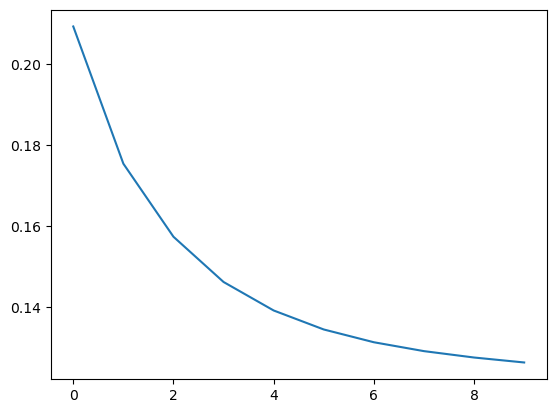

0:00:14.551127
epoch 10:, dice_loss=0.12533168, lr= 0.001
0:00:15.692211
epoch 11:, dice_loss=0.12460864, lr= 0.001
0:00:13.075467
epoch 12:, dice_loss=0.12404617, lr= 0.001
0:00:13.915972
epoch 13:, dice_loss=0.12360730, lr= 0.001
0:00:12.910458
epoch 14:, dice_loss=0.12324806, lr= 0.001
0:00:12.842614
epoch 15:, dice_loss=0.12291993, lr= 0.001
0:00:12.629426
epoch 16:, dice_loss=0.12268713, lr= 0.001
0:00:14.500021
epoch 17:, dice_loss=0.12252283, lr= 0.001
0:00:13.321271
epoch 18:, dice_loss=0.12240450, lr= 0.001
0:00:13.496103
epoch 19:, dice_loss=0.12215455, lr= 0.001


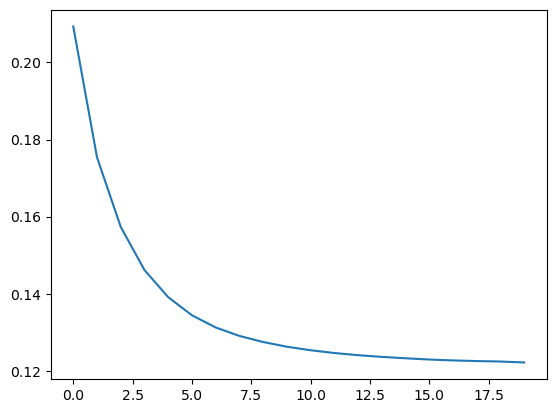

0:00:14.484145
epoch 20:, dice_loss=0.12202425, lr= 0.001
0:00:14.102416
epoch 21:, dice_loss=0.12192465, lr= 0.001
0:00:15.523338
epoch 22:, dice_loss=0.12182137, lr= 0.001
0:00:13.118369
epoch 23:, dice_loss=0.12185781, lr= 0.001
0:00:12.725239
epoch 24:, dice_loss=0.12166562, lr= 0.001
0:00:12.674333
epoch 25:, dice_loss=0.12163264, lr= 0.001
0:00:12.816532
epoch 26:, dice_loss=0.12154423, lr= 0.001
0:00:14.690872
epoch 27:, dice_loss=0.12146936, lr= 0.001
0:00:14.848163
epoch 28:, dice_loss=0.12140119, lr= 0.001
0:00:13.060293
epoch 29:, dice_loss=0.12133861, lr= 0.001


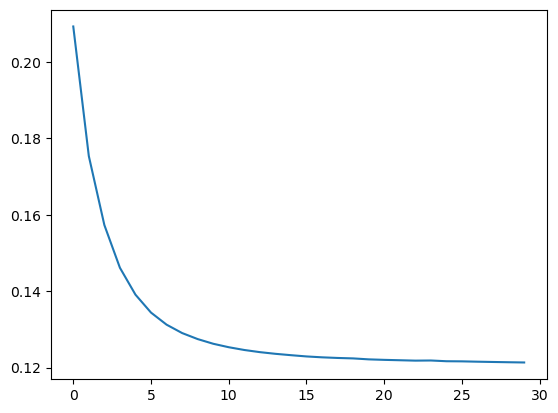

0:00:12.765167
epoch 30:, dice_loss=0.12130469, lr= 0.001
0:00:12.947045
epoch 31:, dice_loss=0.12125081, lr= 0.001
0:00:13.000077
epoch 32:, dice_loss=0.12119927, lr= 0.001
0:00:13.032314
epoch 33:, dice_loss=0.12118632, lr= 0.001
0:00:14.297898
epoch 34:, dice_loss=0.12117423, lr= 0.001
0:00:13.180055
epoch 35:, dice_loss=0.12117417, lr= 0.001
0:00:14.485332
epoch 36:, dice_loss=0.12109867, lr= 0.001
0:00:14.685994
epoch 37:, dice_loss=0.12107375, lr= 0.001
0:00:15.600621
epoch 38:, dice_loss=0.12112887, lr= 0.001
0:00:13.304489
epoch 39:, dice_loss=0.12141582, lr= 0.0005


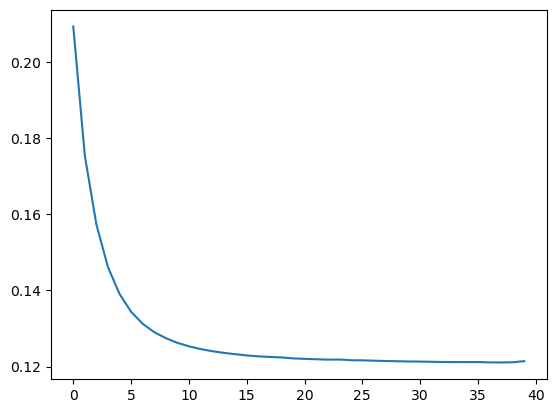

0:00:13.222113
epoch 40:, dice_loss=0.12132581, lr= 0.0005
0:00:12.972277
epoch 41:, dice_loss=0.12110370, lr= 0.0005
0:00:15.252094
epoch 42:, dice_loss=0.12106135, lr= 0.0005
0:00:14.133824
epoch 43:, dice_loss=0.12104246, lr= 0.0005
0:00:14.770713
epoch 44:, dice_loss=0.12102189, lr= 0.0005
0:00:13.233463
epoch 45:, dice_loss=0.12099467, lr= 0.0005
0:00:12.922868
epoch 46:, dice_loss=0.12097218, lr= 0.0005
0:00:14.932038
epoch 47:, dice_loss=0.12095422, lr= 0.0005
0:00:14.829520
epoch 48:, dice_loss=0.12093666, lr= 0.0005
0:00:14.008597
epoch 49:, dice_loss=0.12092821, lr= 0.0005


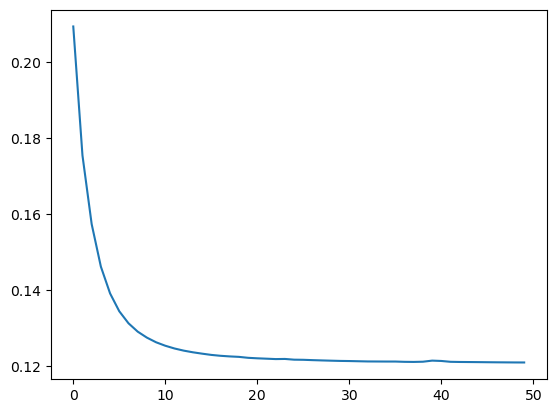

0:00:13.631667
epoch 50:, dice_loss=0.12091487, lr= 0.0005
0:00:13.490263
epoch 51:, dice_loss=0.12090863, lr= 0.0005
0:00:14.914425
epoch 52:, dice_loss=0.12090185, lr= 0.0005
0:00:13.238279
epoch 53:, dice_loss=0.12088978, lr= 0.0005
0:00:15.313574
epoch 54:, dice_loss=0.12088792, lr= 0.0005
0:00:13.161869
epoch 55:, dice_loss=0.12087318, lr= 0.0005
0:00:12.796344
epoch 56:, dice_loss=0.12086709, lr= 0.0005
0:00:12.893656
epoch 57:, dice_loss=0.12086330, lr= 0.0005
0:00:12.824207
epoch 58:, dice_loss=0.12086856, lr= 0.0005
0:00:12.830480
epoch 59:, dice_loss=0.12085105, lr= 0.0005


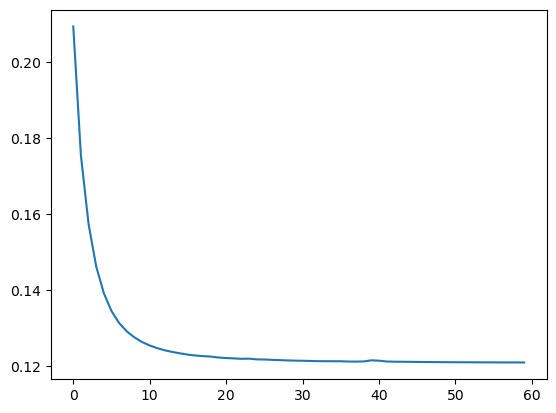

0:00:13.014192
epoch 60:, dice_loss=0.12084717, lr= 0.0005
0:00:13.077964
epoch 61:, dice_loss=0.12083165, lr= 0.0005
0:00:12.860395
epoch 62:, dice_loss=0.12083368, lr= 0.0005
0:00:13.092772
epoch 63:, dice_loss=0.12085376, lr= 0.0005
0:00:12.870189
epoch 64:, dice_loss=0.12089116, lr= 0.0005
0:00:13.248762
epoch 65:, dice_loss=0.12087605, lr= 0.0005
0:00:12.754509
epoch 66:, dice_loss=0.12084232, lr= 0.0005
0:00:12.961582
epoch 67:, dice_loss=0.12083038, lr= 0.0005
0:00:12.945261
epoch 68:, dice_loss=0.12081573, lr= 0.0005
0:00:14.297453
epoch 69:, dice_loss=0.12081888, lr= 0.0005


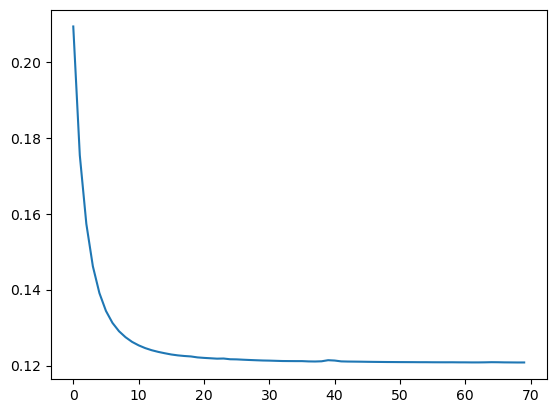

0:00:15.734191
epoch 70:, dice_loss=0.12079994, lr= 0.0005
0:00:13.121721
epoch 71:, dice_loss=0.12079039, lr= 0.0005
0:00:13.245808
epoch 72:, dice_loss=0.12078624, lr= 0.0005
0:00:12.952861
epoch 73:, dice_loss=0.12077415, lr= 0.0005
0:00:14.942113
epoch 74:, dice_loss=0.12076450, lr= 0.0005
0:00:13.030630
epoch 75:, dice_loss=0.12077033, lr= 0.0005
0:00:14.923752
epoch 76:, dice_loss=0.12075484, lr= 0.0005
0:00:14.160465
epoch 77:, dice_loss=0.12074883, lr= 0.0005
0:00:15.198478
epoch 78:, dice_loss=0.12074573, lr= 0.0005
0:00:14.576717
epoch 79:, dice_loss=0.12074123, lr= 0.00025


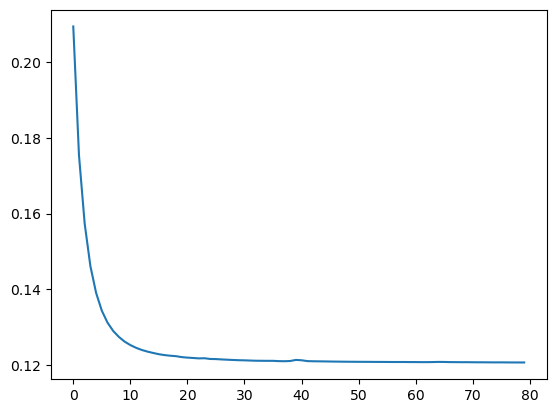

0:00:13.478610
epoch 80:, dice_loss=0.12074589, lr= 0.00025
0:00:13.124679
epoch 81:, dice_loss=0.12074611, lr= 0.00025
0:00:14.000446
epoch 82:, dice_loss=0.12074373, lr= 0.00025
0:00:13.188318
epoch 83:, dice_loss=0.12073997, lr= 0.00025
0:00:13.216006
epoch 84:, dice_loss=0.12073888, lr= 0.00025
0:00:14.875198
epoch 85:, dice_loss=0.12073968, lr= 0.00025
0:00:13.419850
epoch 86:, dice_loss=0.12074311, lr= 0.00025
0:00:13.103188
epoch 87:, dice_loss=0.12073464, lr= 0.00025
0:00:12.644415
epoch 88:, dice_loss=0.12072795, lr= 0.00025
0:00:13.462127
epoch 89:, dice_loss=0.12072460, lr= 0.00025


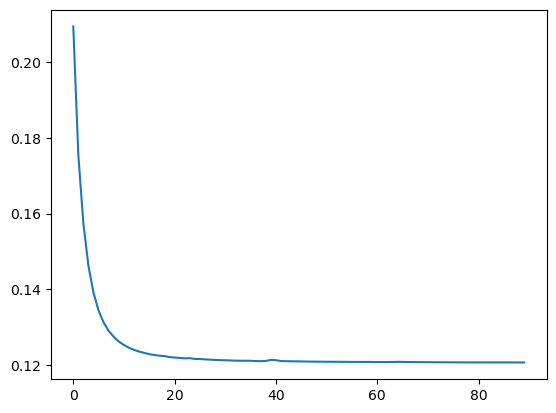

0:00:15.218133
epoch 90:, dice_loss=0.12072500, lr= 0.00025
0:00:14.366981
epoch 91:, dice_loss=0.12072690, lr= 0.00025
0:00:13.896680
epoch 92:, dice_loss=0.12072027, lr= 0.00025
0:00:12.933657
epoch 93:, dice_loss=0.12071712, lr= 0.00025
0:00:13.395283
epoch 94:, dice_loss=0.12071299, lr= 0.00025
0:00:12.737571
epoch 95:, dice_loss=0.12070949, lr= 0.00025
0:00:13.233426
epoch 96:, dice_loss=0.12070469, lr= 0.00025
0:00:13.240097
epoch 97:, dice_loss=0.12070397, lr= 0.00025
0:00:13.062063
epoch 98:, dice_loss=0.12070140, lr= 0.00025
0:00:13.099756
epoch 99:, dice_loss=0.12070100, lr= 0.00025


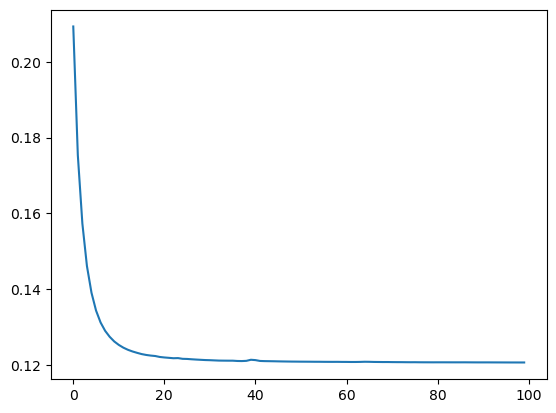

0:00:13.656931
epoch 100:, dice_loss=0.12069962, lr= 0.00025
0:00:13.871462
epoch 101:, dice_loss=0.12070089, lr= 0.00025
0:00:13.659633
epoch 102:, dice_loss=0.12069891, lr= 0.00025
0:00:12.986281
epoch 103:, dice_loss=0.12070077, lr= 0.00025
0:00:12.885371
epoch 104:, dice_loss=0.12069504, lr= 0.00025
0:00:13.330202
epoch 105:, dice_loss=0.12069254, lr= 0.00025
0:00:15.807836
epoch 106:, dice_loss=0.12069289, lr= 0.00025
0:00:13.057275
epoch 107:, dice_loss=0.12069020, lr= 0.00025
0:00:14.038487
epoch 108:, dice_loss=0.12068570, lr= 0.00025
0:00:14.179737
epoch 109:, dice_loss=0.12068379, lr= 0.00025


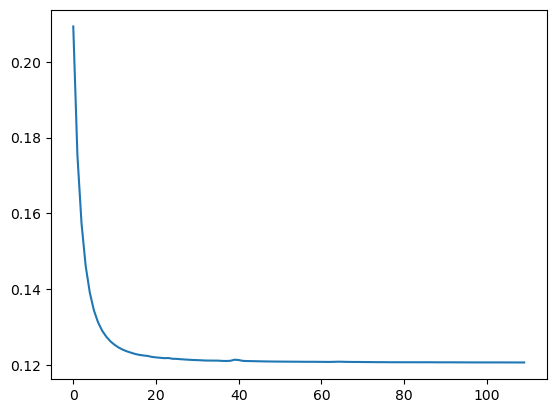

0:00:13.845344
epoch 110:, dice_loss=0.12068243, lr= 0.00025
0:00:12.849494
epoch 111:, dice_loss=0.12070086, lr= 0.00025
0:00:12.725850
epoch 112:, dice_loss=0.12070606, lr= 0.00025
0:00:13.153250
epoch 113:, dice_loss=0.12069452, lr= 0.00025
0:00:12.666479
epoch 114:, dice_loss=0.12068879, lr= 0.00025
0:00:13.951168
epoch 115:, dice_loss=0.12067839, lr= 0.00025
0:00:15.184820
epoch 116:, dice_loss=0.12068005, lr= 0.00025
0:00:16.599867
epoch 117:, dice_loss=0.12075341, lr= 0.00025
0:00:13.015473
epoch 118:, dice_loss=0.12070397, lr= 0.00025
0:00:13.759656
epoch 119:, dice_loss=0.12068317, lr= 0.000125


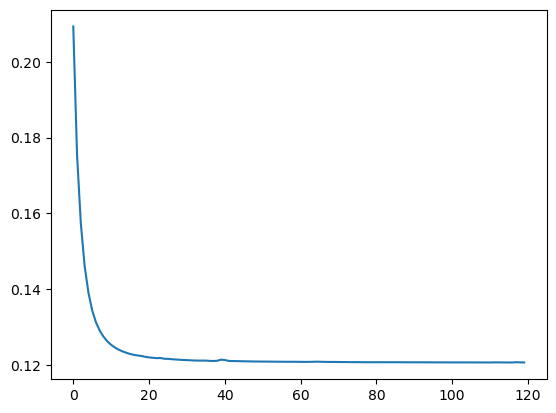

0:00:13.126964
epoch 120:, dice_loss=0.12068150, lr= 0.000125
0:00:13.023380
epoch 121:, dice_loss=0.12068540, lr= 0.000125
0:00:12.736926
epoch 122:, dice_loss=0.12068832, lr= 0.000125
0:00:12.985928
epoch 123:, dice_loss=0.12068854, lr= 0.000125
0:00:12.916012
epoch 124:, dice_loss=0.12068769, lr= 0.000125
0:00:13.120508
epoch 125:, dice_loss=0.12068229, lr= 0.000125
0:00:13.208052
epoch 126:, dice_loss=0.12068095, lr= 0.000125
0:00:13.510216
epoch 127:, dice_loss=0.12068028, lr= 0.000125
0:00:14.678009
epoch 128:, dice_loss=0.12067965, lr= 0.000125
0:00:13.064707
epoch 129:, dice_loss=0.12067959, lr= 0.000125


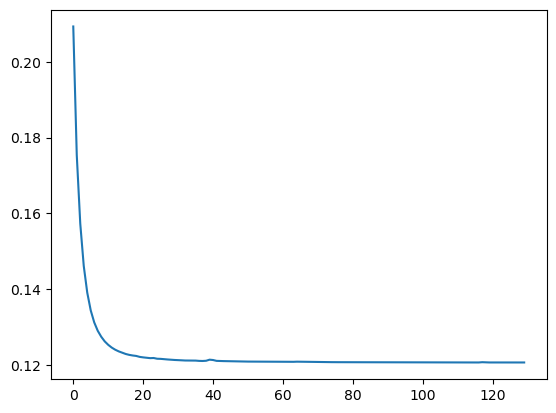

0:00:13.005465
epoch 130:, dice_loss=0.12067929, lr= 0.000125
0:00:14.237763
epoch 131:, dice_loss=0.12067813, lr= 0.000125
0:00:14.817564
epoch 132:, dice_loss=0.12067760, lr= 0.000125
0:00:13.097298
epoch 133:, dice_loss=0.12067629, lr= 0.000125
0:00:14.051879
epoch 134:, dice_loss=0.12067463, lr= 0.000125
0:00:15.180115
epoch 135:, dice_loss=0.12067226, lr= 0.000125
0:00:13.374068
epoch 136:, dice_loss=0.12066977, lr= 0.000125
0:00:14.614015
epoch 137:, dice_loss=0.12066970, lr= 0.000125
0:00:16.040017
epoch 138:, dice_loss=0.12066972, lr= 0.000125
0:00:16.153437
epoch 139:, dice_loss=0.12066873, lr= 0.000125


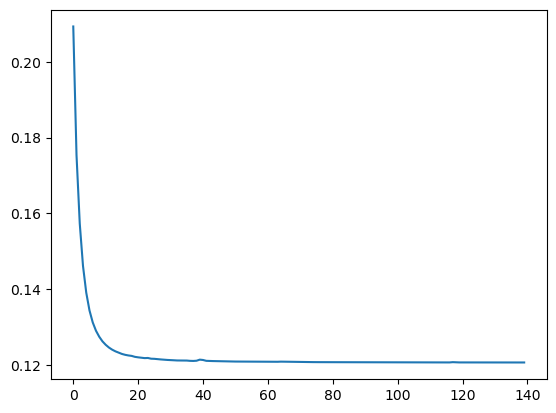

0:00:13.450018
epoch 140:, dice_loss=0.12066666, lr= 0.000125
0:00:13.721331
epoch 141:, dice_loss=0.12066691, lr= 0.000125
0:00:15.363731
epoch 142:, dice_loss=0.12066559, lr= 0.000125
0:00:13.306251
epoch 143:, dice_loss=0.12066542, lr= 0.000125
0:00:13.148049
epoch 144:, dice_loss=0.12066394, lr= 0.000125
0:00:12.830196
epoch 145:, dice_loss=0.12066524, lr= 0.000125
0:00:12.538093
epoch 146:, dice_loss=0.12066723, lr= 0.000125
0:00:13.062817
epoch 147:, dice_loss=0.12066258, lr= 0.000125
0:00:13.798498
epoch 148:, dice_loss=0.12066247, lr= 0.000125
0:00:13.044618
epoch 149:, dice_loss=0.12066011, lr= 0.000125


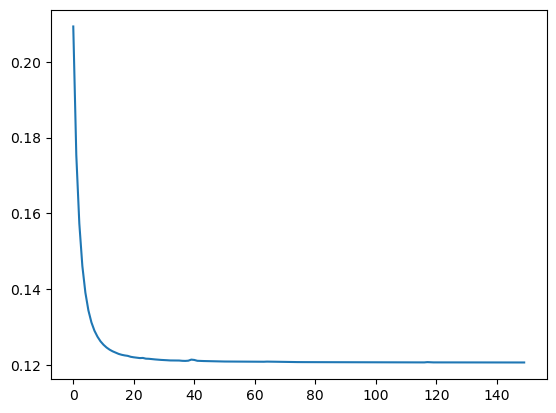

0:00:13.575372
epoch 150:, dice_loss=0.12065810, lr= 0.000125
0:00:12.893226
epoch 151:, dice_loss=0.12065699, lr= 0.000125
0:00:12.812927
epoch 152:, dice_loss=0.12065586, lr= 0.000125
0:00:12.973349
epoch 153:, dice_loss=0.12065289, lr= 0.000125
0:00:12.976200
epoch 154:, dice_loss=0.12065180, lr= 0.000125
0:00:12.868460
epoch 155:, dice_loss=0.12064900, lr= 0.000125
0:00:14.560624
epoch 156:, dice_loss=0.12064920, lr= 0.000125
0:00:14.982805
epoch 157:, dice_loss=0.12064573, lr= 0.000125
0:00:13.163084
epoch 158:, dice_loss=0.12064545, lr= 0.000125
0:00:12.897590
epoch 159:, dice_loss=0.12064173, lr= 6.25e-05


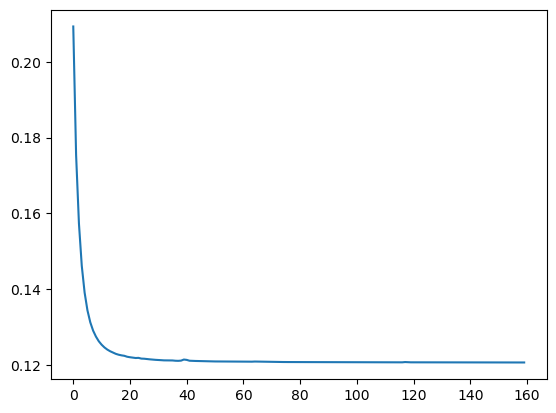

0:00:12.722552
epoch 160:, dice_loss=0.12064140, lr= 6.25e-05
0:00:12.909767
epoch 161:, dice_loss=0.12064667, lr= 6.25e-05
0:00:14.114188
epoch 162:, dice_loss=0.12064997, lr= 6.25e-05
0:00:13.752697
epoch 163:, dice_loss=0.12064819, lr= 6.25e-05
0:00:13.984952
epoch 164:, dice_loss=0.12064692, lr= 6.25e-05
0:00:12.890052
epoch 165:, dice_loss=0.12064404, lr= 6.25e-05
0:00:12.854521
epoch 166:, dice_loss=0.12064107, lr= 6.25e-05
0:00:12.603653
epoch 167:, dice_loss=0.12063864, lr= 6.25e-05
0:00:13.143865
epoch 168:, dice_loss=0.12063639, lr= 6.25e-05
0:00:12.651279
epoch 169:, dice_loss=0.12063475, lr= 6.25e-05


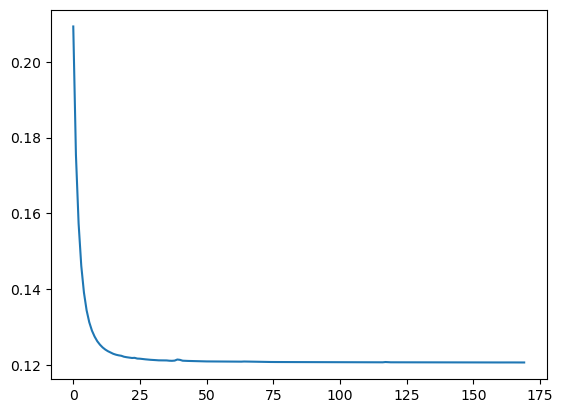

0:00:14.238654
epoch 170:, dice_loss=0.12063316, lr= 6.25e-05
0:00:13.500942
epoch 171:, dice_loss=0.12063186, lr= 6.25e-05
0:00:13.633306
epoch 172:, dice_loss=0.12063060, lr= 6.25e-05
0:00:13.238708
epoch 173:, dice_loss=0.12062929, lr= 6.25e-05
0:00:12.944406
epoch 174:, dice_loss=0.12062811, lr= 6.25e-05
0:00:12.567613
epoch 175:, dice_loss=0.12062716, lr= 6.25e-05
0:00:13.049881
epoch 176:, dice_loss=0.12062623, lr= 6.25e-05
0:00:12.787723
epoch 177:, dice_loss=0.12062547, lr= 6.25e-05
0:00:12.484807
epoch 178:, dice_loss=0.12062553, lr= 6.25e-05
0:00:12.600919
epoch 179:, dice_loss=0.12062543, lr= 6.25e-05


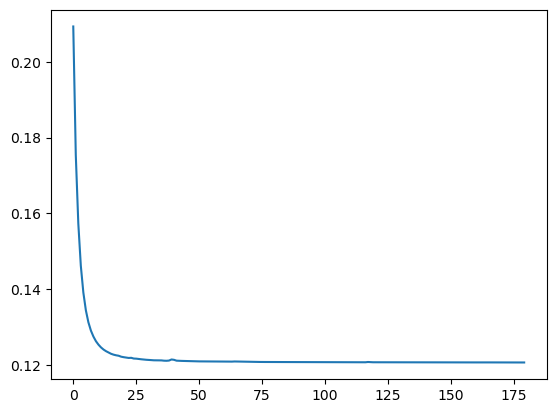

0:00:12.437373
epoch 180:, dice_loss=0.12062380, lr= 6.25e-05
0:00:12.976531
epoch 181:, dice_loss=0.12062355, lr= 6.25e-05
0:00:13.561806
epoch 182:, dice_loss=0.12062327, lr= 6.25e-05
0:00:13.402152
epoch 183:, dice_loss=0.12062332, lr= 6.25e-05
0:00:13.246687
epoch 184:, dice_loss=0.12062128, lr= 6.25e-05
0:00:13.793540
epoch 185:, dice_loss=0.12062119, lr= 6.25e-05
0:00:15.380650
epoch 186:, dice_loss=0.12062101, lr= 6.25e-05
0:00:13.771211
epoch 187:, dice_loss=0.12062144, lr= 6.25e-05
0:00:13.460129
epoch 188:, dice_loss=0.12061905, lr= 6.25e-05
0:00:14.424026
epoch 189:, dice_loss=0.12061903, lr= 6.25e-05


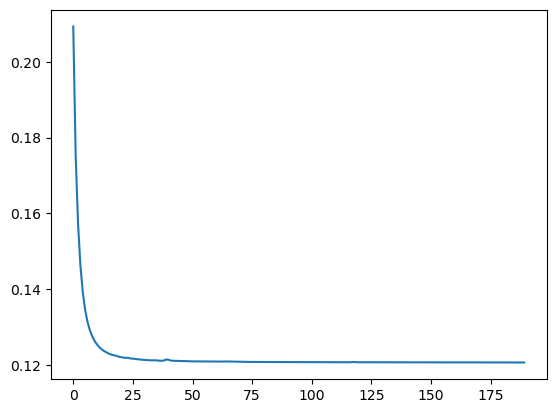

0:00:14.559292
epoch 190:, dice_loss=0.12061857, lr= 6.25e-05


In [ ]:
m.fit()

Validation

In [11]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
best_i = -1
best_dice = 0
for i in range(80,120):
    m.load_model(i)
    pred, masks = m.validate('val', 32)
    # pred = pred.astype(np.uint16)
    dice = 0
    t = 0
    for j  in range(len(pred)):
        if np.count_nonzero(masks[j]) != 0:
            dice += calculate_dice(masks[j], pred[j])
            t += 1
    dice /= t
    print('epoch = ', i,'dice = ', dice)
    if dice > best_dice:
        best_i = i
        best_dice = dice
print('best_i = ', best_i)

epoch =  80 dice =  0.9221781777858379
epoch =  81 dice =  0.9138512128173565
epoch =  82 dice =  0.909883705422343
epoch =  83 dice =  0.9158445247152422
epoch =  84 dice =  0.9121934418006965
epoch =  85 dice =  0.9070587003671022
epoch =  86 dice =  0.9043851106130162
epoch =  87 dice =  0.9118178896679068
epoch =  88 dice =  0.9135511073270933
epoch =  89 dice =  0.9158584418304553
epoch =  90 dice =  0.9090201220144732
epoch =  91 dice =  0.9187618498997555
epoch =  92 dice =  0.9157540488033147
epoch =  93 dice =  0.9216130204156501
epoch =  94 dice =  0.9185477716695559
epoch =  95 dice =  0.922877089826318
epoch =  96 dice =  0.9167076394301177
epoch =  97 dice =  0.9245522988848809
epoch =  98 dice =  0.9195289432244457
epoch =  99 dice =  0.926289826013174
epoch =  100 dice =  0.9190738004711678
epoch =  101 dice =  0.9303136524947289
epoch =  102 dice =  0.921643177393067
epoch =  103 dice =  0.9232910632088731
epoch =  104 dice =  0.9232321469562135
epoch =  105 dice =  0.9

epoch =  115 dice =  0.9332237138488513


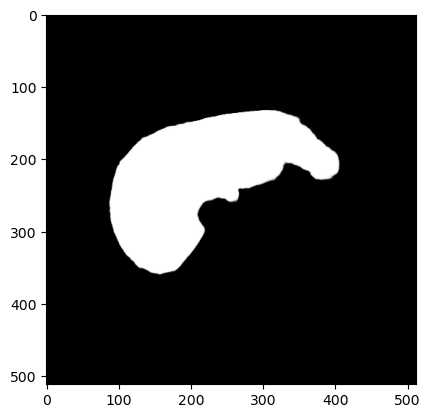

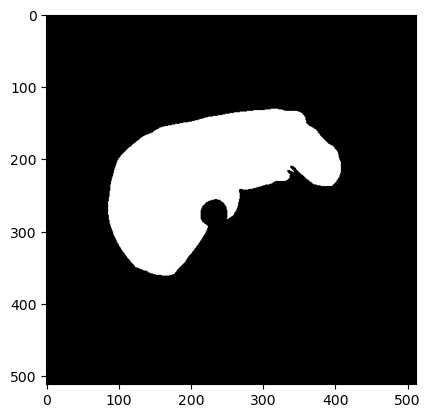

In [12]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
m.load_model(best_i)
pred, masks = m.validate('val', 32)
dice = 0
t = 0
for j  in range(len(pred)):
    if np.count_nonzero(masks[j]) != 0:
        dice += calculate_dice(masks[j], pred[j])
        t += 1
dice /= t
print('epoch = ', best_i,'dice = ', dice)
plt.imshow(pred[25], cmap = 'gray')
plt.show()
plt.imshow(masks[25], cmap = 'gray')

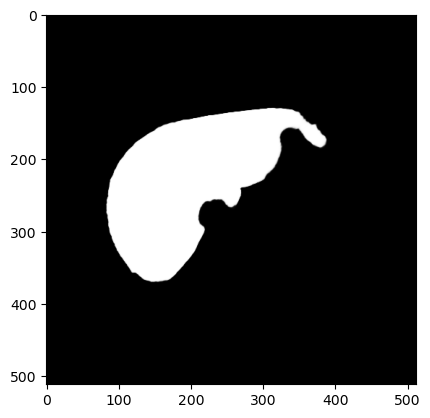

0.9696226499300805


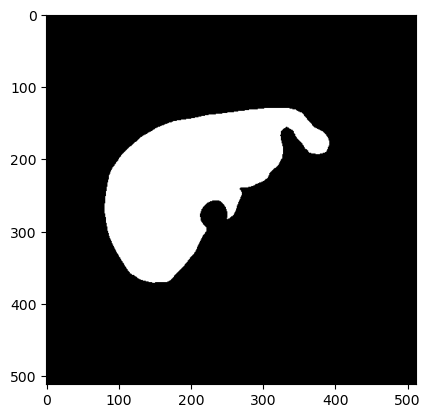

In [14]:
i = 30
plt.imshow(pred[i], cmap = 'gray')
plt.show()
plt.imshow(masks[i], cmap = 'gray')
dice = calculate_dice(masks[i], pred[i])
print(dice)